In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm



from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)

import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known

# plt.style.use("ggplot")
plt.style.use("seaborn-v0_8-paper")


In [2]:
# params

# cfg = ExtractConfig(
#     # model="microsoft/phi-2",
#     # # batch_size=1,
#     # prompt_format="phi",
# )
# cfg

# params
batch_size = 32
lr = 4e-3
wd = 1e-4

MAX_ROWS = 2000

SKIP=5 # skip initial N layers
STRIDE=4 # skip every N layers
DECIMATE=1 # discard N features for speed

device = "cuda:0"
max_epochs = 23

VAE_EPOCH_MULT = 2
l1_coeff = 1.0e-1  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
    # x_feats=x_feats. other use 1e-1


In [3]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_ood = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_276/hidden_states/.ds/ds_OOD_1e9f2652c6cc48e7'
f1_val = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_276/hidden_states/.ds/ds_valtest_afd38b0b5a0cfe5c'
# f1_val = f1_ood
ds_val = Dataset.from_file(f1_val)
ds_ood = Dataset.from_file(f1_ood)

ds_out = datasets.interleave_datasets([ds_val, ds_ood], seed=42, 
                                    #   probabilities=[0.5, 0.5]
                                      )
ds_out2 = filter_ds_to_known(ds_out, verbose=True)

# ds_out2 = ds_out2.select_columns(['end_residual_stream_base', 'end_residual_stream_adapt', 'binary_ans_base', 'binary_ans_adapt'])
# ds_known1 = ds_out
# ds_known1
ds_out2
# 1m 17 sec for 2k samples 1st time, 1 s 2nd time


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


select rows are 74.58% based on knowledge


Dataset({
    features: ['end_logits_base', 'choice_probs_base', 'binary_ans_base', 'label_true_base', 'label_instructed_base', 'instructed_to_lie_base', 'sys_instr_name_base', 'example_i_base', 'ds_string_base', 'template_name_base', 'correct_truth_telling_base', 'correct_instruction_following_base', 'end_residual_Wqkv_base', 'end_residual_fc1_base', 'end_logits_adapt', 'choice_probs_adapt', 'binary_ans_adapt', 'label_true_adapt', 'label_instructed_adapt', 'instructed_to_lie_adapt', 'sys_instr_name_adapt', 'example_i_adapt', 'ds_string_adapt', 'template_name_adapt', 'correct_truth_telling_adapt', 'correct_instruction_following_adapt', 'end_residual_Wqkv_adapt', 'end_residual_fc1_adapt'],
    num_rows: 1121
})

In [4]:
MAX_SAMPLES = min(len(ds_out2), MAX_ROWS*2)
ds_out2 = ds_out2.select(range(0, MAX_SAMPLES))


In [5]:
insample_datasets = list(set(ds_val['ds_string_base']))
outsample_datasets = list(set(ds_ood['ds_string_base']))
print(insample_datasets, outsample_datasets)


ds_trainval = ds_out2.filter(lambda ds_string_base: ds_string_base in insample_datasets, input_columns=['ds_string_base'])
ds_test = ds_out2.filter(lambda ds_string_base: ds_string_base not in outsample_datasets, input_columns=['ds_string_base'])

MAX_SAMPLES = min(len(ds_trainval), MAX_ROWS)
ds_trainval = ds_trainval.select(range(MAX_SAMPLES))

MAX_SAMPLES = min(len(ds_test), MAX_ROWS)
ds_test = ds_test.select(range(MAX_SAMPLES))

len(ds_trainval), len(ds_test)


['sst2', 'hans', 'super_glue:rte', 'glue:qnli', 'amazon_polarity'] ['super_glue:boolq', 'imdb', 'super_glue:axg']


Filter:   0%|          | 0/1121 [00:00<?, ? examples/s]

(639, 639)

In [6]:
def shape(v):
    if isinstance(v, (Tensor, np.ndarray)):
        return v.shape
    elif isinstance(v, dict):
        return {k:shape(v) for k,v in v.items()}
    elif isinstance(v, list):
        return len(v)
    else:
        return 1
{k:shape(v) for k,v in ds_trainval.with_format('torch')[0].items()}


{'end_logits_base': torch.Size([51200]),
 'choice_probs_base': torch.Size([2]),
 'binary_ans_base': torch.Size([]),
 'label_true_base': torch.Size([]),
 'label_instructed_base': torch.Size([]),
 'instructed_to_lie_base': torch.Size([]),
 'sys_instr_name_base': 1,
 'example_i_base': torch.Size([]),
 'ds_string_base': 1,
 'template_name_base': 1,
 'correct_truth_telling_base': torch.Size([]),
 'correct_instruction_following_base': torch.Size([]),
 'end_residual_Wqkv_base': torch.Size([32, 7679]),
 'end_residual_fc1_base': torch.Size([32, 10239]),
 'end_logits_adapt': torch.Size([51200]),
 'choice_probs_adapt': torch.Size([2]),
 'binary_ans_adapt': torch.Size([]),
 'label_true_adapt': torch.Size([]),
 'label_instructed_adapt': torch.Size([]),
 'instructed_to_lie_adapt': torch.Size([]),
 'sys_instr_name_adapt': 1,
 'example_i_adapt': torch.Size([]),
 'ds_string_adapt': 1,
 'template_name_adapt': 1,
 'correct_truth_telling_adapt': torch.Size([]),
 'correct_instruction_following_adapt': torc

In [7]:
def ds2xy(row):
    X1 = torch.stack([row['end_residual_fc1_base'], row['end_residual_fc1_adapt']], dim=-1)
    X2 = torch.stack([row['end_residual_Wqkv_base'], row['end_residual_Wqkv_adapt']], dim=-1)
    # X = torch.concat([row['end_residual_fc1_base'], row['end_residual_Wqkv_base']], dim=-1)[SKIP::STRIDE] # [layers, features, base/adapt]
    X = torch.concat([X1, X2], dim=1)[SKIP::STRIDE, ::DECIMATE] # [layers, features, base/adapt]
    # X = X1[SKIP::STRIDE] # [layers, features, base/adapt]
    y = row['binary_ans_base']-row['binary_ans_adapt']
    return dict(X=X, y=y)


def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y
    
    """
    ds = (ds
          .with_format("torch")
          .select_columns(['end_residual_fc1_base', 'end_residual_fc1_adapt',
                                                'end_residual_Wqkv_base', 'end_residual_Wqkv_adapt',
                                                'binary_ans_base', 'binary_ans_adapt'])
          .map(ds2xy)
          .select_columns(['X', 'y'])
    )
    return ds


ds_trainval2 = prepare_ds(ds_trainval)
ds_test2 = prepare_ds(ds_test)

# next(iter(ds_trainval2)).keys()


Map:   0%|          | 0/639 [00:00<?, ? examples/s]

In [8]:
from src.datasets.dm import DeceptionDataModule

# .select_columns(self.x_cols)

# TEMP try with the counterfactual residual stream...
dm = DeceptionDataModule(ds_trainval2, batch_size=batch_size, num_workers=5)
dm.setup("train")
dm


In [9]:
dm_ood = DeceptionDataModule(ds_test2, batch_size=batch_size, 
                         )
dm_ood.setup("test")


# Get importance matrix from adapter

Wqkv torch.Size([32, 7680])
fc1 torch.Size([32, 10240])


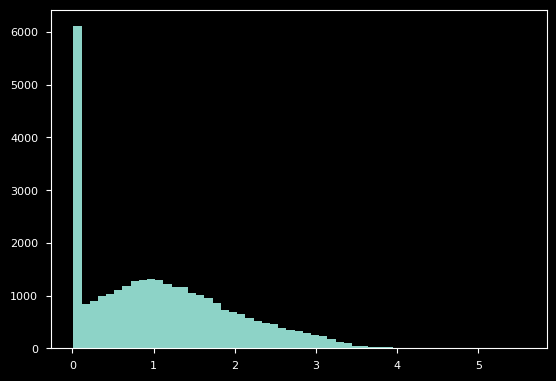

In [10]:
from src.probes.importance_matrix import get_importance_matrix


f = "/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_276/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f)[SKIP::STRIDE, ::DECIMATE]
plt.hist(importance_matrix.flatten(), bins=55);


In [11]:
shape1 = ds_test2[0]['X'][:, :, 0].shape
shape2= importance_matrix.shape
np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


# Model

In [12]:
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

from torch import dropout
from src.probes.pl_ranking_probe import InceptionBlock, LinBnDrop, ConvBlock


class Encoder(nn.Module):
    def __init__(self, n_layers, n_channels, hs, c_out, ks=[7, 5, 3], dropout=0):
        super().__init__()
        self.n_layers = n_layers

        self.conv = nn.Sequential(
            nn.BatchNorm1d(n_channels, affine=False),
            InceptionBlock(n_channels, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks),
            InceptionBlock(hs * 4, hs, ks=ks),
        )

        self.fc = nn.Sequential(
            LinBnDrop(hs * 4 * n_layers, c_out * n_layers, dropout=dropout),
            nn.Linear(c_out * n_layers, c_out * n_layers),
        )

    def forward(self, x):
        x = self.conv(x)
        x = rearrange(x, "b c l -> b (c l)")
        x = self.fc(x)
        x = rearrange(x, "b (c l) -> b c l", l=self.n_layers)
        return x


class Decoder(nn.Module):
    def __init__(self, n_latent, n_layers, hs, c_out=1, ks=[7, 5, 3], dropout=0):
        super().__init__()
        hs = hs * 2
        self.layers = n_layers

        self.fc = nn.Sequential(
            nn.BatchNorm1d(
                n_latent * n_layers, affine=False
            ),  # center it, regularize it
            LinBnDrop(n_latent * n_layers, hs * n_layers, dropout=dropout),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            InceptionBlock(hs, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, conv_dropout=dropout),
            InceptionBlock(hs * 4, hs, ks=ks, coord=True),
            InceptionBlock(hs * 4, hs, ks=ks),
            nn.Conv1d(hs * 4, c_out, 1),
        )

    def forward(self, x):
        x = rearrange(x, "b l c -> b (l c)")
        x = self.fc(x)
        x = rearrange(x, "b (c l) -> b c l", l=self.layers)
        x = self.conv(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(
        self, c_in, depth=3, n_hidden=32, n_latent=32, l1_coeff: float = 1.0, dropout=0, importance_matrix=None
    ):
        super().__init__()
        self.l1_coeff = l1_coeff
        self.importance_matrix = importance_matrix
        n_layers, n_channels = c_in
        self.enc = Encoder(n_layers, n_channels, n_hidden, n_latent, dropout=dropout)
        self.dec = Decoder(
            n_latent, n_layers, n_hidden // 4, c_out=n_channels, dropout=dropout
        )
    #     self.apply_weight_norm(self.dec)
    #     self.apply_weight_norm(self.enc)

    # def apply_weight_norm(self, net):
    #     for m in net.modules():
    #         if isinstance(m, nn.Conv1d):
    #             # I think it's 1. In the example they use 2, but their weights are transposed before use
    #             torch.nn.utils.parametrizations.weight_norm(m, dim=1)

    def forward(self, h: Float[Tensor, "batch_size n_hidden n_channels"]):
        device = next(self.parameters()).device
        h = h.to(device)
        latent = self.enc(h)
        h_rec = self.dec(latent)

        if self.importance_matrix is None:
            importance_matrix = torch.ones_like(h_rec)
        else:
            importance_matrix = self.importance_matrix.to(device)

        # Compute loss, return values
        l2_loss = (
            ((h_rec - h) * importance_matrix).pow(2).mean(-1).mean(1)
        )  # shape [batch_size sum(neurons) mean(layers)] - punish the model for not reconstructing the input
        l1_loss = (
            latent.abs().sum(-1).sum(1)
        )  # shape [batch_size sum(latent) sum(layers)] - punish the model for large latent values
        loss = (self.l1_coeff * l1_loss + l2_loss).mean(0)  # scalar

        return l1_loss, l2_loss, loss, latent, h_rec


In [13]:
def recursive_requires_grad(model, mode: bool = False):
    print(f"requires_grad: {mode}")
    for param in model.parameters():
        param.requires_grad = mode


In [14]:
from src.probes.pl_base import PLBase
from torchmetrics.functional import accuracy


class PLAE(PLBase):
    def __init__(
        self,
        c_in,
        epoch_steps,
        max_epochs,
        depth=0,
        lr=4e-3,
        weight_decay=1e-9,
        hs=64,
        n_latent=32,
        l1_coeff=1,
        dropout=0,
        **kwargs,
    ):
        super().__init__(epoch_steps=epoch_steps, max_epochs=max_epochs, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()

        self.ae = AutoEncoder(
            c_in,
            n_hidden=hs,
            n_latent=n_latent,
            depth=depth,
            l1_coeff=l1_coeff,
            dropout=dropout,
        )
        n_layers, n_channels = c_in
        n = n_latent * n_layers
        self.head = nn.Sequential(
            LinBnDrop(n, n // 4, dropout=dropout),
            LinBnDrop(n // 4, n // 12, dropout=dropout),
            nn.Linear(n // 12, 1),
            # nn.Tanh(),
        )
        self._ae_mode = True

    def ae_mode(self, mode=0):
        """
        mode 0, train the ae
        mode 1, train only the prob
        mode 2, train both
        """
        self._ae_mode = mode
        recursive_requires_grad(self.ae, mode in [0, 2])

    def forward(self, x):
        if x.ndim == 4:
            x = x.squeeze(3)
        x = rearrange(x, "b l h -> b h l")
        # if not self._ae_mode:
        #     with torch.no_grad():
        #         l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)
        # else:
        l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)

        latent2 = rearrange(latent, "b l h -> b (l h)")
        pred = self.head(latent2).squeeze(1)
        return dict(
            pred=pred,
            l1_loss=l1_loss,
            l2_loss=l2_loss,
            loss=loss,
            latent=latent,
            h_rec=h_rec,
        )

    def _step(self, batch, batch_idx, stage="train"):
        # if stage=='train':
        #     # Normalize the decoder weights before each optimization step (from https://colab.research.google.com/drive/1rPy82rL3iZzy2_Rd3F82RwFhlVnnroIh?usp=sharing#scrollTo=q1JctT2Pvw-r)
        #     # Presumably this is a way to implement weight norm to regularize the decoder
        #     self.normalize_decoder()
        device = next(self.parameters()).device
        x, y = batch['X'], batch['y']
        x = x.to(device)
        y = y.to(device)
        x0 = x[..., 0]
        x1 = x[..., 1]
        info0 = self(x0)
        info1 = self(x1)
        ypred1 = info1["pred"]
        ypred0 = info0["pred"]

        if stage == "pred":
            return (ypred1 - ypred0).float()

        pred_loss = F.smooth_l1_loss(ypred1 - ypred0, y)
        rec_loss = info0["loss"] + info1["loss"]
        l1_loss = (info0["l1_loss"] + info1["l1_loss"]).mean()
        l2_loss = (info0["l2_loss"] + info1["l2_loss"]).mean()

        y_cls = ypred1 > ypred0  # switch2bool(ypred1-ypred0)
        self.log(
            f"{stage}/acc",
            accuracy(y_cls, y > 0, "binary"),
            on_epoch=True,
            on_step=False,
        )
        self.log(
            f"{stage}/loss_pred",
            float(pred_loss),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        self.log(
            f"{stage}/loss_rec",
            float(rec_loss),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        self.log(f"{stage}/l1_loss", l1_loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/l2_loss", l2_loss, on_epoch=True, on_step=False)
        self.log(
            f"{stage}/n",
            float(len(y)),
            on_epoch=True,
            on_step=False,
            reduce_fx=torch.sum,
        )
        if self._ae_mode == 0:
            return rec_loss
        elif self._ae_mode == 1:
            return pred_loss
        elif self._ae_mode == 2:
            return pred_loss * 50000 + rec_loss


# Train

### Metrics


In [15]:
def get_acc_subset(df, query, verbose=True):
    if query:
        df = df.query(query)
    acc = (df["probe_pred"] == df["y"]).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits["test"]
    df_test = dm.df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred > 0.0

    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits["val"]
        df_val = dm.df.iloc[splits[0] : splits[1]].copy()
        df_val["probe_pred"] = y_val_pred > 0.0

        df_test = pd.concat([df_val, df_test])

    if verbose:
        print("probe results on subsets of the data")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "llm_ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "llm_ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=False
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["instructed_to_lie==False", "instructed_to_lie==True"],
        columns=["llm_ans==label_instructed", "llm_ans!=label_instructed"],
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    d1.index.name = "instructed to"
    d1.columns.name = "llm gave"
    print("probe accuracy for quadrants")
    display(d1.round(2))

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)


### Setup

In [16]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]


10 5
torch.Size([32, 7, 4480, 2]) x


In [17]:
%%time
# oh no, this is very slow
g = iter(dl_train)
b = next(g)
b = next(g)


CPU times: user 7.65 ms, sys: 192 ms, total: 200 ms
Wall time: 7.67 s


In [18]:

net = PLAE(
    c_in=c_in,
    epoch_steps=max_epochs,
    max_epochs=max_epochs * VAE_EPOCH_MULT,
    lr=lr,
    weight_decay=wd,
    hs=128,
    depth=3,
    # dropout=0.05,
    n_latent=64,
    l1_coeff=l1_coeff, 
)
print(c_in)
x1= x[..., 0]
with torch.no_grad():
    y = net(x1)
{k: v.abs().mean() for k, v in y.items()}


torch.Size([7, 4480])


{'pred': tensor(0.4114),
 'l1_loss': tensor(204.9963),
 'l2_loss': tensor(203.9169),
 'loss': tensor(224.4165),
 'latent': tensor(0.4576),
 'h_rec': tensor(0.3854)}

In [19]:
x.shape


torch.Size([32, 7, 4480, 2])

In [20]:
from torchinfo import summary

summary(net, input_data=x1, depth=4)  # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                                  Output Shape              Param #
PLAE                                                    [32, 4480, 7]             --
├─AutoEncoder: 1-1                                      [32]                      --
│    └─Encoder: 2-1                                     [32, 64, 7]               --
│    │    └─Sequential: 3-1                             [32, 512, 7]              --
│    │    │    └─BatchNorm1d: 4-1                       [32, 4480, 7]             --
│    │    │    └─InceptionBlock: 4-2                    [32, 512, 7]              1,397,120
│    │    │    └─InceptionBlock: 4-3                    [32, 512, 7]              381,312
│    │    │    └─InceptionBlock: 4-4                    [32, 512, 7]              381,312
│    │    │    └─InceptionBlock: 4-5                    [32, 512, 7]              381,312
│    │    │    └─InceptionBlock: 4-6                    [32, 512, 7]              381,312
│    │    └─Sequential: 3-2      

### Train autoencoder

In [21]:
net.ae_mode(0)
trainer1 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    # devices=2,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for perf

requires_grad: True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 6.4 M 
1 | head | Sequential  | 54.8 K
-------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.983    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


5/10 [00:04<00:04, 1.10it/s, v_num=295, val/loss_pred=0.0849, val/loss_rec=9.58e+5, train/loss_pred=0.350, train/loss_rec=9.8e+5]


In [22]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results


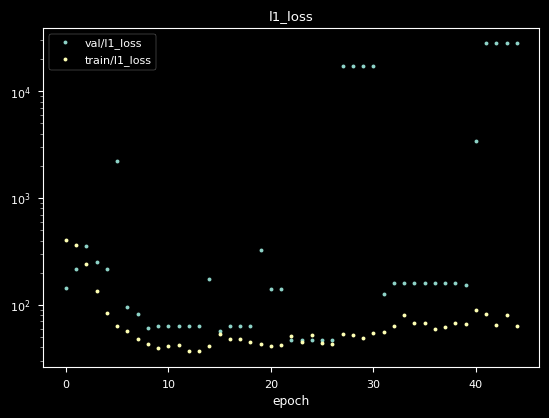

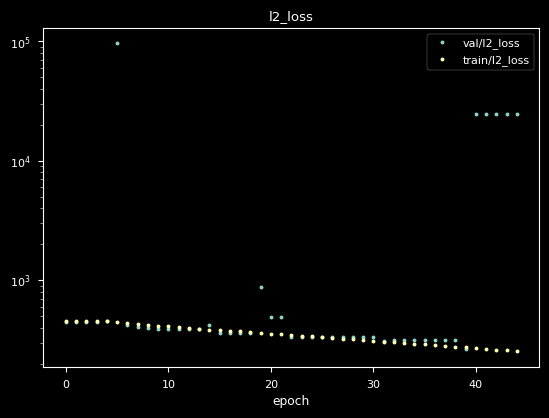

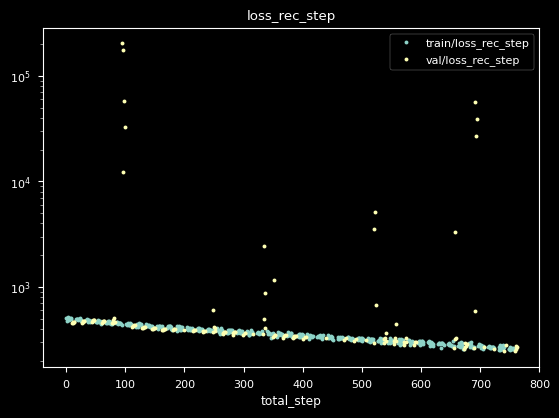

,step,train/loss_pred_step,train/loss_rec_step,val/loss_pred_step,val/loss_rec_step,val/loss_pred_epoch,val/l1_loss,val/acc,val/loss_rec_epoch,val/l2_loss,val/n,train/n,train/l1_loss,train/loss_pred_epoch,train/acc,train/l2_loss,train/loss_rec_epoch
epoch,,,,,,,,,,,,,,,,,
0.0,9,0.199934,508.042511,0.016869,466.363892,0.017093,144.221893,0.46250,461.226562,446.804382,160.0,319.0,403.715576,0.226344,0.510972,457.857361,498.228943
1.0,19,0.106668,479.072662,0.074828,473.800690,0.064029,218.099930,0.44375,468.098450,446.288483,160.0,319.0,363.405396,0.234098,0.523511,457.078064,493.418549
2.0,29,0.260621,475.775391,0.317313,486.424591,0.275421,358.927002,0.43750,480.792145,444.899414,160.0,319.0,239.728592,0.214629,0.460815,455.740601,479.713470
3.0,39,0.194495,466.853760,0.301481,473.986908,0.277073,252.571091,0.44375,468.411865,443.154724,160.0,319.0,135.049179,0.166888,0.526646,453.992615,467.497559
4.0,49,0.119615,448.092072,0.605777,465.829834,0.669552,218.161819,0.43750,473.097961,451.281738,160.0,319.0,84.055557,0.143066,0.470219,450.990387,459.395966
5.0,59,0.106477,437.719055,9.173607,32447.851562,35.750061,2203.088623,0.45625,96359.390625,96139.078125,160.0,319.0,63.052956,0.139873,0.473354,446.026947,452.332184
6.0,69,0.099702,433.197876,0.245573,432.980225,0.198242,96.178032,0.51250,427.948425,418.330627,160.0,319.0,57.291828,0.114894,0.498433,438.987946,444.717194
7.0,79,0.131583,419.805664,0.089419,421.385101,0.134129,82.626465,0.44375,415.469727,407.207092,160.0,319.0,47.972862,0.107948,0.467085,431.262848,436.060089
8.0,89,0.062995,423.891174,0.496486,409.422028,0.281321,61.079731,0.46875,404.322327,398.214325,160.0,319.0,42.815536,0.101212,0.501567,423.542908,427.824463


In [23]:

df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=True)
plt.show()
plot_hist(df_hist_step, ['loss_rec_step'], logy=True)

df_hist


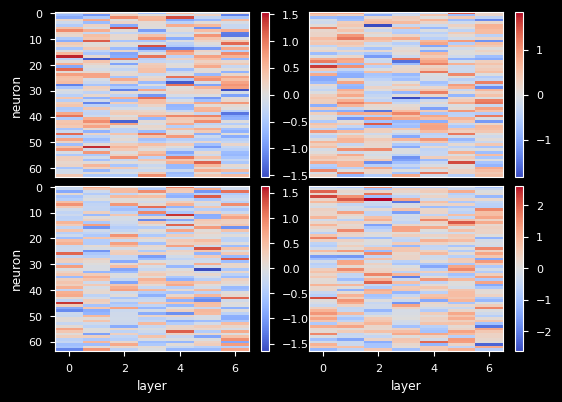

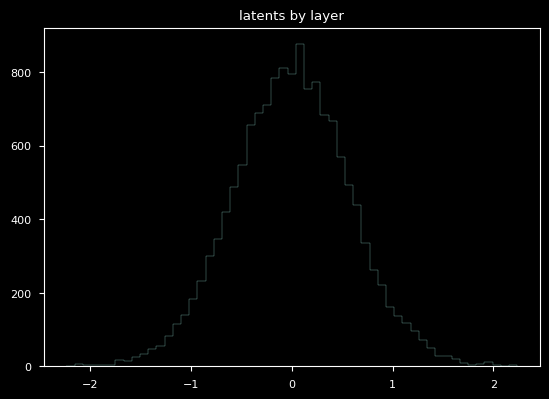

In [24]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):

    # plot image of latent space
    vmax = latent.abs().max()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].abs().max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xlabel("layer")
        plt.ylabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b n l -> (b n) l").flatten()
    vmax = (latentf.abs().mean() + 5 * latentf.abs().std()).item()
    plt.hist(latentf, bins=55, range=[-vmax, vmax], histtype="step")
    plt.title("latents by layer")
    plt.show()


latent = y["latent"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
plot_latent(latent)


### Train probe

In [25]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)


requires_grad: False


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 6.4 M 
1 | head | Sequential  | 54.8 K
-------------------------------------
54.8 K    Trainable params
6.4 M     Non-trainable params
6.5 M     Total params
25.983    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=23` reached.


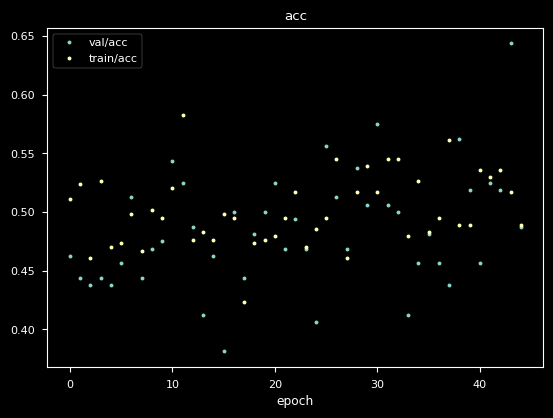

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.5485893487930298     │    0.48750001192092896    │          0.53125          │
│       test/l1_loss        │            nan            │     5313.44677734375      │            nan            │
│       test/l2_loss        │            nan            │            nan            │            nan            │
│   test/loss_pred_epoch    │            nan            │            nan            │            nan            │
│    test/loss_rec_epoch    │            nan            │            nan            │            nan            │
│          test/n           │           319.0           │           160.0           │           160.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.5289514660835266     │
│       test/l1_loss        │            nan            │
│       test/l2_loss        │            nan            │
│   test/loss_pred_epoch    │            nan            │
│    test/loss_rec_epoch    │            nan            │
│          test/n           │           639.0           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'DeceptionDataModule' object has no attribute 'df'

In [26]:

df_hist, _ = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred', 'acc'])

# predict
dl_test = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])

testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]


#### how well does it generalize to other datasets?


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer1, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs


### Train end-to-end


In [ ]:
net.ae_mode(2)
trainer2 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred', 'acc'])

# predict
dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])

testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer1, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs
